In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

import keras
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot as plt

In [10]:
print('GPU Device:', tf.test.gpu_device_name())

GPU Device: /device:GPU:0


# Hyper parameter training

In [11]:
Train = pd.read_csv('../TrainTestData/cle_train.csv')
Test = pd.read_csv('../TrainTestData/cle_test.csv')

X_train = Train.iloc[:,:-1]
Y_train = Train.iloc[:,-1]

In [12]:
def model_builder(hp):
    hp_units_1 = hp.Int('units_FC1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units_FC2', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = Sequential()
    model.add(Dense(hp_units_1, input_shape=(35,), activation='relu'))
    model.add(Dense(hp_units_2, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  metrics=['accuracy'])

    return model

In [13]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='../Models/Baseline_DNN/HP',
                     project_name = 'DNN_HP')

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

with tf.device('/device:GPU:0'):
    tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first FC
layer is {best_hps.get('units_FC1')}, The optimal number of units in the second FC
layer is {best_hps.get('units_FC2')},
The optimal learning rate is {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 00m 23s]
val_accuracy: 0.7650702595710754

Best val_accuracy So Far: 0.7650702595710754
Total elapsed time: 00h 06m 29s

The hyperparameter search is complete. The optimal number of units in the first FC
layer is 64, The optimal number of units in the second FC
layer is 192,
The optimal learning rate is 0.001



# Training

In [17]:
def DNN_train():
    
    #load the data
    Train = pd.read_csv('../TrainTestData/com_train.csv')
    Test = pd.read_csv('../TrainTestData/com_test.csv')
    
    X_train = Train.iloc[:,:-1]
    Y_train = Train.iloc[:,-1]

    X_test = Test.iloc[:,:-1]
    Y_test = Test.iloc[:,-1]
    
    #train the CNN model
    filepath = "../Models/Baseline_DNN/train/baseline_DNN_model_at_epoch_{epoch}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq="epoch")
    with tf.device('/device:GPU:0'):
        history = model.fit(X_train, Y_train,validation_split = 0.1, epochs=20, batch_size=32,callbacks=[checkpoint])
    
    #save model history
    np.save('../Models/Baseline_DNN/baseline_DNN_hist.npy',history.history)
    #history=np.load('my_history.npy',allow_pickle='TRUE').item()

    
    #plot train val loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def DNN_test():
    testlists = ['../TrainTestData/com_test.csv','../TrainTestData/cle_test.csv','../TrainTestData/vir_test.csv',
                '../TrainTestData/hun_test.csv','../TrainTestData/swi_test.csv']
    for i in testlists:
        Test = pd.read_csv(i)

        X_test = Test.iloc[:,:-1]
        Y_test = Test.iloc[:,-1]

        Y_pred = model.predict(X_test).argmax(axis=1)

        cm = confusion_matrix(Y_pred, Y_test)
        print("this is the test for " + str(i[-12:][:3]))
        print(cm)
        print(classification_report(Y_test, Y_pred,digits = 4))
        print("============================================")

Epoch 1/20
3722/3724 [============================>.] - ETA: 0s - loss: 0.5040 - accuracy: 0.7559
Epoch 1: saving model to ../Models/Baseline_DNN/train\baseline_DNN_model_at_epoch_1.hdf5
3724/3724 [==============================] - 13s 3ms/step - loss: 0.5041 - accuracy: 0.7559 - val_loss: 0.4980 - val_accuracy: 0.7588
Epoch 2/20
3722/3724 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.7607
Epoch 2: saving model to ../Models/Baseline_DNN/train\baseline_DNN_model_at_epoch_2.hdf5
3724/3724 [==============================] - 10s 3ms/step - loss: 0.4965 - accuracy: 0.7607 - val_loss: 0.4947 - val_accuracy: 0.7626
Epoch 3/20
3710/3724 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.7614
Epoch 3: saving model to ../Models/Baseline_DNN/train\baseline_DNN_model_at_epoch_3.hdf5
3724/3724 [==============================] - 12s 3ms/step - loss: 0.4952 - accuracy: 0.7615 - val_loss: 0.4934 - val_accuracy: 0.7635
Epoch 4/20
3714/3724 [===============

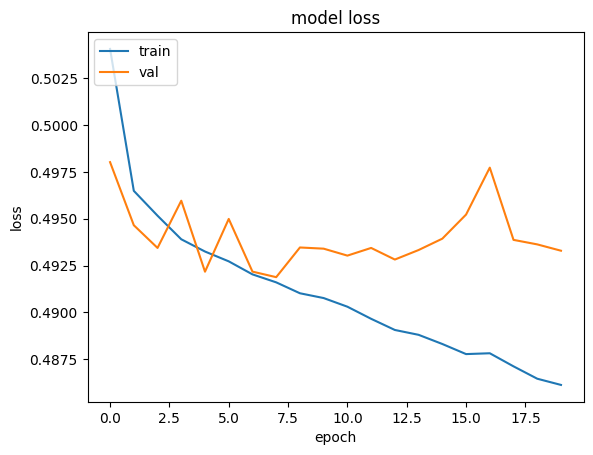

In [19]:
# DNN
model = tuner.hypermodel.build(best_hps)
DNN_train()

# Testing

In [20]:
model = load_model('../Models/Baseline_DNN/train/baseline_DNN_model_at_epoch_8.hdf5')
DNN_test()

1773/1773 [==============================] - 2s 1ms/step
this is the test for com
[[30046  9229]
 [ 4167 13294]]
              precision    recall  f1-score   support

           0     0.7650    0.8782    0.8177     34213
           1     0.7614    0.5902    0.6650     22523

    accuracy                         0.7639     56736
   macro avg     0.7632    0.7342    0.7413     56736
weighted avg     0.7636    0.7639    0.7571     56736

444/444 [==============================] - 1s 2ms/step
this is the test for cle
[[7482 2298]
 [1053 3351]]
              precision    recall  f1-score   support

           0     0.7650    0.8766    0.8170      8535
           1     0.7609    0.5932    0.6667      5649

    accuracy                         0.7637     14184
   macro avg     0.7630    0.7349    0.7419     14184
weighted avg     0.7634    0.7637    0.7571     14184

444/444 [==============================] - 0s 975us/step
this is the test for vir
[[7613 2264]
 [1034 3273]]
              pre